In [1]:
target_size = (150,150)
batch_size = 20
train_val_split = 0.2
num_classes = 5
nb_epochs =100
#init_epoch = 29
wandb_resume_state = True
exp_name = 'test6'

In [2]:
import shutil
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from keras.models import save_model
import cv2
from tensorflow.keras.metrics import AUC, Precision, Recall
import wandb
from wandb.keras import WandbCallback

In [3]:
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [4]:
train_val_split = 0.2

In [5]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/customdataset/Feature_Extraction', target_size = (150,150), batch_size = 20, class_mode = 'categorical', subset='training') 
validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/customdataset/Feature_Extraction', target_size = (150,150), batch_size = 20,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [6]:
labels = list(train_generator.class_indices.keys())

In [7]:
from keras.models import Sequential
from tensorflow.keras import models, optimizers
from tensorflow.keras.applications import VGG16
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.5)) #dropout - to reduce over fitting - deactivate 50% of neurons in each epoch randomly
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
print(model.summary())

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 16,813,381
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
model.compile(loss='categorical_crossentropy',optimizer = optimizers.RMSprop(learning_rate=2e-5) , metrics=['accuracy', Precision(),  Recall(), AUC()])

In [9]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping( patience=3, verbose=1)

In [10]:
history = model.fit(train_generator,steps_per_epoch = len(train_generator),
                          validation_data = validation_generator,
                          validation_steps =len( validation_generator),epochs = nb_epochs ,callbacks=[early_stopping])

Epoch 1/100
147/147 [==============================] - 45s 211ms/step - loss: 0.9452 - accuracy: 0.6718 - precision: 0.7807 - recall: 0.5647 - auc: 0.8876 - val_loss: 0.7714 - val_accuracy: 0.7127 - val_precision: 0.8662 - val_recall: 0.5404 - val_auc: 0.9272
Epoch 2/100
147/147 [==============================] - 27s 182ms/step - loss: 0.8014 - accuracy: 0.7182 - precision: 0.8028 - recall: 0.6319 - auc: 0.9187 - val_loss: 0.7625 - val_accuracy: 0.7360 - val_precision: 0.8294 - val_recall: 0.5718 - val_auc: 0.9253
Epoch 3/100
147/147 [==============================] - 29s 197ms/step - loss: 0.7682 - accuracy: 0.7318 - precision: 0.8124 - recall: 0.6370 - auc: 0.9250 - val_loss: 0.7439 - val_accuracy: 0.7373 - val_precision: 0.8195 - val_recall: 0.5964 - val_auc: 0.9298
Epoch 4/100
147/147 [==============================] - 28s 189ms/step - loss: 0.7357 - accuracy: 0.7356 - precision: 0.8117 - recall: 0.6561 - auc: 0.9311 - val_loss: 0.7437 - val_accuracy: 0.7305 - val_precision: 0.9158

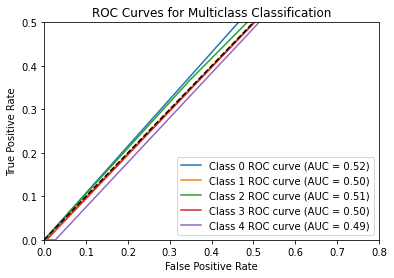

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error
import numpy as np
# Make predictions for the test set
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)
y_true = validation_generator.classes

# Binarize the true labels and predictions
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

# Compute the AUC for each class
aucs = []
for i in range(y_true_bin.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    auc = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
    aucs.append(auc)
    plt.plot(fpr, tpr, label='Class {} ROC curve (AUC = {:.2f})'.format(i, auc))

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 0.8])
plt.ylim([0.0, 0.5])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()
y_true = np.argmax(y_true_bin, axis=1)
y_pred = np.argmax(y_pred_bin, axis=1)


In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Generate predictions for the test set
#y_pred = model.predict(validation_generator)
#y_pred = np.argmax(y_pred,axis=1)
#y_true = validation_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = validation_generator.class_indices.keys()

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [13]:
#save model
model_json = model.to_json()
with open('model_vgg16.json', 'w') as json_file:
    json_file.write(model_json)

model_saved = save_model(model, './weights.hdf5')
#load model
with open('model_vgg16.json', 'r') as json_file:
    json_saved_model = json_file.read()

model_loaded = tf.keras.models.model_from_json(json_saved_model)
model_loaded.load_weights('weights.hdf5')
model_loaded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#test single image
path = '/kaggle/input/traindata/train/3/0104b032c141.png'
image = cv2.imread(path)
image = cv2.resize(image, (150,150))
image = image/ 255    #normalise
#print(image.shape)
image = image.reshape(-1, 150,150,3)      #reshape in format to send more than one image to predict
#print(image.shape)

result = model_loaded(image)
#print(result)  #probabilities that the image belong to each class
result = np.argmax(result, axis=1)

if(result==0):
    print('Grade 0')
elif(result == 1):
    print('Grade 1')
elif(result == 2):
    print('Grade 2')
elif(result == 3):
    print('Grade 3')
else:
    print('Grade 4')

Grade 0


In [14]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
r_train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/redlesion-customdataset/RedLesion_CustomDataset', target_size = (150,150), batch_size = 32, class_mode = 'categorical', subset='training') 
r_validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/redlesion-customdataset/RedLesion_CustomDataset', target_size = (150,150), batch_size = 32,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [16]:
history = model.fit(r_train_generator,steps_per_epoch = len(r_train_generator),
                          validation_data = r_validation_generator,
                          validation_steps =len( r_validation_generator),epochs = nb_epochs ,callbacks=[early_stopping])

Epoch 1/100
92/92 [==============================] - 439s 5s/step - loss: 1.0749 - accuracy: 0.6547 - precision: 0.7578 - recall: 0.5114 - auc: 0.8829 - val_loss: 0.8948 - val_accuracy: 0.6662 - val_precision: 0.8876 - val_recall: 0.4104 - val_auc: 0.9077
Epoch 2/100
92/92 [==============================] - 355s 4s/step - loss: 0.7778 - accuracy: 0.7083 - precision: 0.8038 - recall: 0.6012 - auc: 0.9240 - val_loss: 0.7042 - val_accuracy: 0.7291 - val_precision: 0.8468 - val_recall: 0.5746 - val_auc: 0.9380
Epoch 3/100
92/92 [==============================] - 360s 4s/step - loss: 0.6741 - accuracy: 0.7387 - precision: 0.8240 - recall: 0.6452 - auc: 0.9429 - val_loss: 0.6742 - val_accuracy: 0.7332 - val_precision: 0.8246 - val_recall: 0.6238 - val_auc: 0.9423
Epoch 4/100
92/92 [==============================] - 345s 4s/step - loss: 0.6182 - accuracy: 0.7680 - precision: 0.8362 - recall: 0.6810 - auc: 0.9515 - val_loss: 0.6505 - val_accuracy: 0.7428 - val_precision: 0.8566 - val_recall: 0